In [1]:
from functools import partial
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import KBio

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
mse = mean_squared_error

from matplotlib.gridspec import GridSpec

In [17]:
Gauss1 = KBio.Gaussian(sigma=1e-2)
Gauss2 = KBio.Gaussian(sigma=2e-1)
lin = KBio.Polynomial(degree=1, c=0)
poly_quad = KBio.Polynomial(degree=2, c=0.01)
poly_cubic = KBio.Polynomial(degree=3, c=0.01)
poly_quartic = KBio.Polynomial(degree=4, c=0.01)
poly_quintic = KBio.Polynomial(degree=5, c=0.01)

In [18]:
operator_kernels = [Gauss2, lin, poly_quad, poly_cubic, poly_quartic, poly_quintic]

In [19]:
# Simulation parameters
beta = 4e-1
gamma = 1e-1
T_final = 3e1
dt = 1e-2

# declare the simulator
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 10, S0 = 90)

# number of samples for the training and test sets
n_samples_oscillatory = 20  # 20
n_samples_oscillatory_test = 50  # 50

# Use consistent forcings for standardization between trials
amplitudes_list = np.linspace(0.1, 0.5, 5)
amplitudes_list = np.sort(amplitudes_list)

np.random.seed(1947)
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
# frequencies = np.random.uniform(1, 6, n_samples_oscillatory)
frequencies = [np.random.normal(i+1, 0.1, n_samples_oscillatory // 5) for i in range(5)]
frequencies = np.concatenate(frequencies)



# Derivatives of the forcing function to consider
alphas_list = [[0], [1], [2]]


In [20]:
amplitudes_list

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [21]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [22]:
# feature functions
feature_functions = []

def ident(index, x, u, u_deriv_list):
    """ Identity feature function for the $index$-th derivative of the function"""
    if np.abs(int(index) - index) > 1e-10:
        raise ValueError('Only the first derivative is available')
    if index == 0:
        return u
    else:
        return u_deriv_list[index]
# Get the first 2 derivatives and the function itself
for i in range(1,3):
    feature_functions.append(partial(ident, i))

# quadratic feature function
def quadratic(index, x, u, u_deriv_list):
    """ Quadratic feature function for the $index$-th derivative of the function

    The feature function is $u^2$ for the function itself and $2u u'$ for the first derivative.
    """

    if index == 0:
        return u**2
    elif index == 1:
        return 2*u*u_deriv_list[index]
    else:
        raise ValueError('Higher derivatives are not implemented')

feature_functions.append(partial(quadratic, 0))

In [23]:
# Should take ~50 seconds for 6x5 = 30 samples
# First, just get the data
training_data = {}
testing_data = {}
for amplitude_ref in amplitudes_list:
    # print(f"{kernel}_{amplitude_ref}")

    amplitudes = np.full(n_samples_oscillatory,amplitude_ref)

    ## Training data
    # np.random.seed(7)
    forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, 
                         frequency in zip(amplitudes, shifts, frequencies)]
    grids_oscillatory = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory)]
    for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
        sim(grid, forcing = fn)


    training_data[amplitude_ref] = {'grids': grids_oscillatory, 'forcing_functions': forcing_functions}

    ## Test data
    amplitude_test = np.full(n_samples_oscillatory_test, amplitude_ref)
    shift_test = np.random.uniform(0, np.pi, n_samples_oscillatory_test)
    frequencies_test = np.random.uniform(1, 6, n_samples_oscillatory_test)

    forcing_functions_test = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, 
                              frequency in zip(amplitude_test, shift_test, frequencies_test)]
    grids_oscillatory_test = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory_test)]

    for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory_test, amplitude_test, shift_test, 
                                                     frequencies_test, forcing_functions_test):
        sim(grid, forcing = fn)

    testing_data[amplitude_ref] = {'grids': grids_oscillatory_test, 'forcing_functions': forcing_functions_test}


In [24]:
# Should take ~40 seconds for 6x5 = 30 samples
# Now smooth the data
smoothed_training = {}
smoothed_testing = {}
x_mean = None
x_std = None
for amplitude_ref in amplitudes_list:
    print(f"Amplitude {amplitude_ref}")
    training_data_amplitude = training_data[amplitude_ref]["grids"]
    testing_data_amplitude = testing_data[amplitude_ref]["grids"]
    if x_mean is None:  # same grid for all, only do this once
        x_mean = np.mean(training_data_amplitude[0].grid_tensors[0])
        x_std = np.std(training_data_amplitude[0].grid_tensors[0])

    # standardize the data

    x_data_train = np.stack([grid.grid_tensors[0] for grid in training_data_amplitude])
    x_data_test = np.stack([grid.grid_tensors[0] for grid in testing_data_amplitude])
    x_data_train = (x_data_train - x_mean) / x_std
    x_data_test = (x_data_test - x_mean) / x_std

    y_data_train = np.stack([grid.grid_tensors_values for grid in training_data_amplitude])
    y_data_test = np.stack([grid.grid_tensors_values for grid in testing_data_amplitude])

    f_data_train = np.stack([grid.grid_tensors_forcing for grid in training_data_amplitude])
    f_data_test = np.stack([grid.grid_tensors_forcing for grid in testing_data_amplitude])

    # smooth the data
    _, _, u_smoothed_train = KBio.kernel_smoothing(Gauss1, x_grid=x_data_train, u_data=y_data_train,
                                                   alpha_list=alphas_list, f_data=f_data_train,
                                                   nugget=1e-8)
    _, _, u_smoothed_test = KBio.kernel_smoothing(Gauss1, x_grid=x_data_test, u_data=y_data_test,
                                                  alpha_list=alphas_list, f_data=f_data_test,
                                                  nugget=1e-8)

    # Store the data
    smoothed_training[amplitude_ref] = {"u_smoothed": u_smoothed_train,
                                        "x_points": training_data_amplitude[0].grid_list,
                                        "x_normalized": x_data_train,
                                        "x_mean": x_mean,
                                        "x_std": x_std,
                                        "f_data": f_data_train}
    smoothed_testing[amplitude_ref] =  {"u_smoothed": u_smoothed_test,
                                        "x_points": testing_data_amplitude[0].grid_list,
                                        "x_normalized": x_data_test,
                                        "x_mean": x_mean,
                                        "x_std": x_std,
                                        "f_data": f_data_test}

Amplitude 0.1
Reshaping x_grid in smoother
(20, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(50, 301, 1)
n_grid_pts:  301
Amplitude 0.2
Reshaping x_grid in smoother
(20, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(50, 301, 1)
n_grid_pts:  301
Amplitude 0.30000000000000004
Reshaping x_grid in smoother
(20, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(50, 301, 1)
n_grid_pts:  301
Amplitude 0.4
Reshaping x_grid in smoother
(20, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(50, 301, 1)
n_grid_pts:  301
Amplitude 0.5
Reshaping x_grid in smoother
(20, 301, 1)
n_grid_pts:  301
Reshaping x_grid in smoother
(50, 301, 1)
n_grid_pts:  301


In [25]:
models_by_op = {}
preds_by_op = {}
errors_by_op = {}
residuals_by_op = {}
for amplitude_ref in amplitudes_list:
    # Smoothed data
    u_smoothed_test = smoothed_testing[amplitude_ref]["u_smoothed"]
    u_smoothed_train = smoothed_training[amplitude_ref]["u_smoothed"]

    # get the grid data
    x_data_train = smoothed_training[amplitude_ref]["x_normalized"]
    x_data_points = smoothed_training[amplitude_ref]["x_points"]
    x_data_test = smoothed_testing[amplitude_ref]["x_normalized"]

    f_data_train = smoothed_training[amplitude_ref]["f_data"]
    f_data_test = smoothed_testing[amplitude_ref]["f_data"]

    # Assemble the features
    F0_flat = KBio.assemble_features(x_grid_list=x_data_points, u_smoothed=u_smoothed_train[0],
                                     multi_derivatives=u_smoothed_train, function_list=feature_functions,
                                     flatten=True)
    ftrain_flat = f_data_train.reshape(-1, 1)  # back into the grid
    # Compute normalization

    F0_test = KBio.assemble_features(x_grid_list=x_data_points, u_smoothed=u_smoothed_test[0],
                                     multi_derivatives=u_smoothed_test, function_list=feature_functions,
                                     flatten=False)
    # F0_test_flat = F0_test.reshape(-1, F0_test.shape[-1])  # back into the grid

    # Flatten F0 on
    F0_means = np.mean(F0_flat, axis=0)
    # F0_means = np.mean(F0, axis=0)
    F0_stds = np.std(F0_flat, axis=0)

    # Shouldn't have any 0's, but be safe here.
    F0 = np.divide((F0_flat - F0_means), F0_stds, where = (F0_stds != 0))
    F0_test = np.divide((F0_test - F0_means), F0_stds, where = (F0_stds != 0))
    
    for kernel in operator_kernels:
        # Smoothing the training data
        model, weight_vector = KBio.learn_DE_form(kernel=kernel, s_features=F0, f_labels=ftrain_flat, nugget=0.5)
        models_by_op[(amplitude_ref, kernel)] = {"model": model, "weight_vector": weight_vector}

        # Evaluate the model on the test data
        preds = []
        for index in range(F0_test.shape[0]):
            _, p = model(F0_test[index,:])
            preds.append(p)
            #plt.plot(x_data_points, p)
            #plt.plot(x_data_points, f_data_test[index,:].T, linestyle='--')
            # Put the kernel and amplitude in the title
            #plt.title(f"{kernel}_{amplitude_ref} - {index}")
            #plt.show()
        preds = np.hstack(preds)

        preds_by_op[(amplitude_ref, kernel)] = preds
        errors_by_op[(amplitude_ref, kernel, "mse")] = mse(f_data_test.T, np.asarray(preds))
        errors_by_op[(amplitude_ref, kernel, "rel_mse")] = mse(f_data_test.T, np.asarray(preds))/mse(f_data_test.T, np.zeros_like(f_data_test.T))
        errors_by_op[(amplitude_ref, kernel, "rel L2")] = np.linalg.norm(f_data_test.T - np.asarray(preds))/np.linalg.norm(f_data_test.T)
        errors_by_op[(amplitude_ref, kernel, "L2")] = np.linalg.norm(f_data_test.T - np.asarray(preds))
        residuals_by_op[(amplitude_ref, kernel)] = f_data_test.T - np.asarray(preds)
        # break
    # break


(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020) (6020, 1)
(301, 6020

In [26]:
kernels_display = [Gauss2, lin, poly_quad, poly_cubic, poly_quartic]

In [27]:
from matplotlib import colormaps
import matplotlib as mpl
import matplotlib.cm as cm


In [30]:
amplitude_ref

0.5

In [31]:
f_data_test.shape

(50, 301)

C:\Users\jyyoo\AppData\Local\Temp\ipykernel_26284\3779628080.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


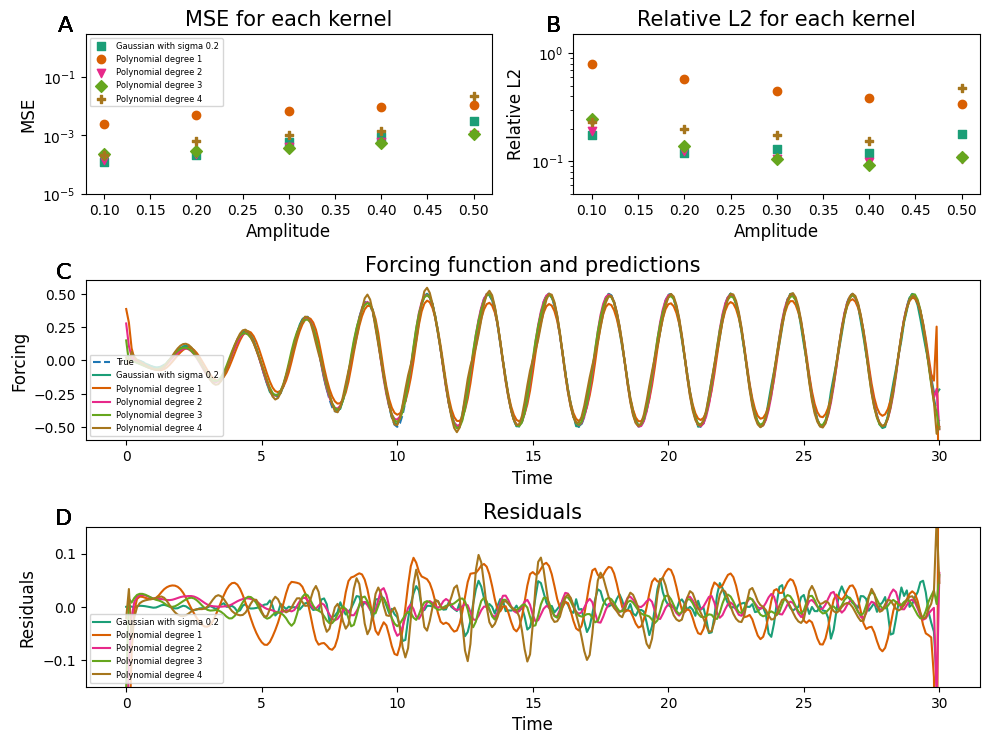

In [43]:

fig = plt.figure(figsize=(10,12), constrained_layout=True)

gs = GridSpec(5, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])

markers = ["s", "o", "v", "D", "P", "X"]
colors = cm.Dark2(np.linspace(0, 1, len(kernels_display)+1))
letters = "ABCD"

for i, kernel in enumerate(kernels_display):
    mse_values = [errors_by_op[(amplitude, kernel, "mse")] for amplitude in amplitudes_list]
    ax1.scatter(amplitudes_list, mse_values, label=f"{kernel}", marker=markers[i], color=colors[i])
    ax1.set_yscale('log')
    ax1.set_ylim(1e-5, 3)
    ax1.set_xlabel('Amplitude', fontsize=12)
    ax1.set_ylabel('MSE', fontsize = 12)
    ax1.set_title('MSE for each kernel', fontsize=15)
    ax1.legend(loc=2, prop={'size': 6})
    ax1.text(-0.05, 1.05, letters[0], ha='center', va='center', color='black', transform=ax1.transAxes, fontsize=16)


for i, kernel in enumerate(kernels_display):
    L2_values = [errors_by_op[(amplitude, kernel, "rel L2")] for amplitude in amplitudes_list]
    ax2.scatter(amplitudes_list, L2_values, label=f"{kernel}", marker=markers[i], color=colors[i])
    ax2.set_yscale('log')
    ax2.set_ylim(5e-2, 1.5)
    ax2.set_xlabel('Amplitude', fontsize=12)
    ax2.set_ylabel('Relative L2', fontsize=12)
    ax2.set_title('Relative L2 for each kernel', fontsize=15)
    ax2.text(-0.05, 1.05, letters[1], ha='center', va='center', color='black', transform=ax2.transAxes, fontsize=16)
    

amplitude_ref = amplitudes_list[-1]
x_data_points = smoothed_testing[amplitude_ref]["x_points"]
f_data_test = smoothed_testing[amplitude_ref]["f_data"]
u_smoothed_test = smoothed_testing[amplitude_ref]["u_smoothed"]
x_data_test = smoothed_testing[amplitude_ref]["x_normalized"]
F0_test = KBio.assemble_features(x_grid_list=x_data_points, u_smoothed=u_smoothed_test[0],
                                 multi_derivatives=u_smoothed_test, function_list=feature_functions,
                                 flatten=False)

for i, kernel in enumerate(kernels_display):
    preds = preds_by_op[(amplitude_ref, kernel)]
    if i == 0:
        y = f_data_test[4,:].T
        ax3.set_ylim(1.2 * np.min(y), 1.2 * np.max(y))

        ax3.plot(x_data_points, y, linestyle='--', label='True')
    ax3.plot(x_data_points, preds[:,4], label=f"{kernel}", color = colors[i])
    ax3.set_xlabel('Time', fontsize=12)
    ax3.set_ylabel('Forcing', fontsize=12)
    ax3.set_title('Forcing function and predictions', fontsize=15)   
    ax3.legend(loc=3, prop={'size': 6})
    ax3.text(-0.025, 1.05, letters[2], ha='center', va='center', color='black', transform=ax3.transAxes, fontsize=16)

  
   
for i, kernel in enumerate(kernels_display):
    residuals = residuals_by_op[(amplitude_ref, kernel)]
    ax4.plot(x_data_points, residuals[:,4], label=f"{kernel}", color = colors[i])
    ax4.set_ylim(-0.15, 0.15)
    ax4.set_xlabel('Time', fontsize=12)
    ax4.set_ylabel('Residuals', fontsize=12)
    ax4.set_title('Residuals', fontsize=15)
    ax4.legend(loc=3, prop={'size': 6})
    ax4.text(-0.025, 1.05, letters[3], ha='center', va='center', color='black', transform=ax4.transAxes, fontsize=16)


plt.tight_layout()
# plt.show()
for fmt in ["png", "pdf", "svg", "eps"]:
    plt.savefig(f"../Figures/Experiment1_plots.{fmt}", format=fmt)
 

Experimental results for the SIS model. 
Panels A and B show the test error of the learned function with five kernels. 
Panel C displays a test forcing function along with its predictions, computed by the five kernels. 
Panel D presents the residuals between the test forcing function and the predictions from Panel C.